# GOING DEEPER 01 : ResNet Ablation Study

## 준비한 데이터

- Cats vs Dogs 데이터셋

## 0. 라이브러리 import 및 데이터셋 준비

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras

### 데이터셋 준비

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [4]:
ds_info.features["label"].num_classes

2

In [5]:
ds_info.features["label"].names

['cat', 'dog']

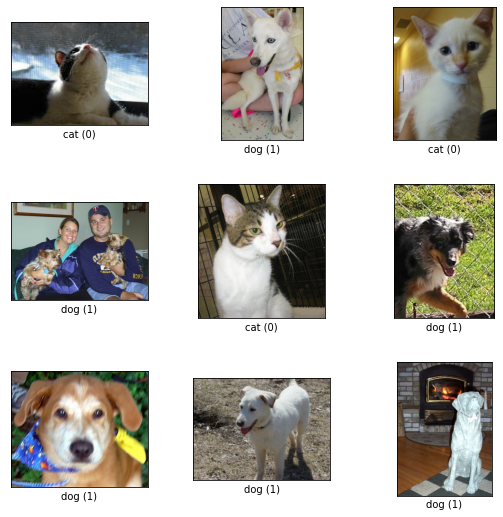

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

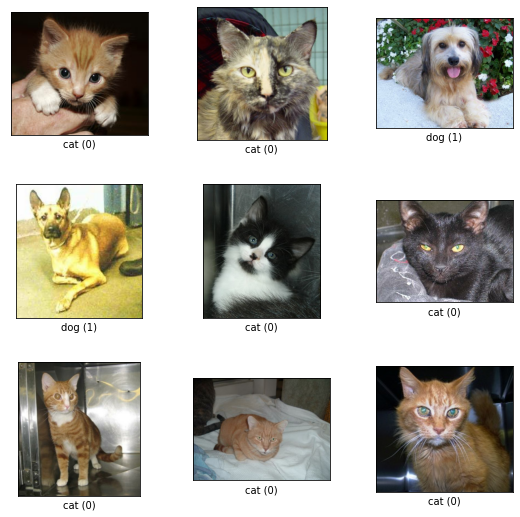

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 1. ResNet 기본 블록 구성하기

In [9]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [10]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [11]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## 2. ResNet-34, ResNet-50 Complete Model

### ResNet-34

In [12]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

### ResNet-50

In [13]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

## 3. 일반 네트워크(plain network) 만들기

In [14]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [15]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### Plain-34

In [16]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

### Plain-50

In [17]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [18]:
del resnet_34
del resnet_50
del plain_34
del plain_50

## 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### 모델별 학습

In [19]:
BATCH_SIZE = 16
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### - ResNet-34

In [20]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 320s 258ms/step - loss: 2.1968 - accuracy: 0.5790 - val_loss: 1.3172 - val_accuracy: 0.6117
Epoch 2/10
1163/1163 [==============================] - 284s 244ms/step - loss: 1.0919 - accuracy: 0.6461 - val_loss: 1.7360 - val_accuracy: 0.5071
Epoch 3/10
1163/1163 [==============================] - 284s 245ms/step - loss: 0.7819 - accuracy: 0.6917 - val_loss: 0.6935 - val_accuracy: 0.7151
Epoch 4/10
1163/1163 [==============================] - 285s 245ms/step - loss: 0.6712 - accuracy: 0.7264 - val_loss: 0.6544 - val_accuracy: 0.7308
Epoch 5/10
1163/1163 [==============================] - 285s 245ms/step - loss: 0.6511 - accuracy: 0.7442 - val_loss: 0.6969 - val_accuracy: 0.7043
Epoch 6/10
1163/1163 [==============================] - 285s 245ms/step - loss: 0.6127 - accuracy: 0.7653 - val_loss: 0.9115 - val_accuracy: 0.6386
Epoch 7/10
1163/1163 [==============================] - 285s 245ms/step - loss: 0.5784 - accuracy: 0.7880 - val_

In [21]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/aiffel/aiffel/data/history_resnet_34.csv', index=False)

### - ResNet-50

In [22]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 268s 200ms/step - loss: 5.4438 - accuracy: 0.5848 - val_loss: 2.9074 - val_accuracy: 0.6698
Epoch 2/10
1163/1163 [==============================] - 248s 213ms/step - loss: 2.4726 - accuracy: 0.6980 - val_loss: 2.2381 - val_accuracy: 0.5410
Epoch 3/10
1163/1163 [==============================] - 221s 190ms/step - loss: 1.4071 - accuracy: 0.7482 - val_loss: 6.4812 - val_accuracy: 0.5321
Epoch 4/10
1163/1163 [==============================] - 221s 190ms/step - loss: 1.0263 - accuracy: 0.7678 - val_loss: 1.0173 - val_accuracy: 0.6743
Epoch 5/10
1163/1163 [==============================] - 221s 190ms/step - loss: 0.8166 - accuracy: 0.8095 - val_loss: 1.0139 - val_accuracy: 0.6588
Epoch 6/10
1163/1163 [==============================] - 221s 190ms/step - loss: 0.7620 - accuracy: 0.8121 - val_loss: 1.5146 - val_accuracy: 0.5097
Epoch 7/10
1163/1163 [==============================] - 221s 190ms/step - loss: 0.6650 - accuracy: 0.8457 - val_

In [23]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/aiffel/aiffel/data/history_resnet_50.csv', index=False)

### - Plain-34

In [24]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 280s 235ms/step - loss: 1.8634 - accuracy: 0.5165 - val_loss: 1.2993 - val_accuracy: 0.4972
Epoch 2/10
1163/1163 [==============================] - 272s 234ms/step - loss: 1.0965 - accuracy: 0.5204 - val_loss: 0.9385 - val_accuracy: 0.4864
Epoch 3/10
1163/1163 [==============================] - 273s 234ms/step - loss: 0.9265 - accuracy: 0.5090 - val_loss: 3.6199 - val_accuracy: 0.5123
Epoch 4/10
1163/1163 [==============================] - 273s 235ms/step - loss: 0.8918 - accuracy: 0.5204 - val_loss: 0.7961 - val_accuracy: 0.4847
Epoch 5/10
1163/1163 [==============================] - 272s 234ms/step - loss: 0.8599 - accuracy: 0.5074 - val_loss: 0.7634 - val_accuracy: 0.4864
Epoch 6/10
1163/1163 [==============================] - 272s 234ms/step - loss: 0.7971 - accuracy: 0.5060 - val_loss: 0.7489 - val_accuracy: 0.5237
Epoch 7/10
1163/1163 [==============================] - 272s 234ms/step - loss: 0.7611 - accuracy: 0.5072 - val_

In [25]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/aiffel/aiffel/data/history_plain_34.csv', index=False)

### - Plain-50

In [26]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 459s 372ms/step - loss: 4.0230 - accuracy: 0.5235 - val_loss: 2.1883 - val_accuracy: 0.5075
Epoch 2/10
1163/1163 [==============================] - 409s 351ms/step - loss: 2.0111 - accuracy: 0.5070 - val_loss: 1.5780 - val_accuracy: 0.5132
Epoch 3/10
1163/1163 [==============================] - 409s 352ms/step - loss: 1.5128 - accuracy: 0.5070 - val_loss: 1.3142 - val_accuracy: 0.4856
Epoch 4/10
1163/1163 [==============================] - 409s 352ms/step - loss: 1.3543 - accuracy: 0.5080 - val_loss: 1.2623 - val_accuracy: 0.5746
Epoch 5/10
1163/1163 [==============================] - 408s 351ms/step - loss: 1.1753 - accuracy: 0.5184 - val_loss: 1.0530 - val_accuracy: 0.5142
Epoch 6/10
1163/1163 [==============================] - 408s 351ms/step - loss: 1.0294 - accuracy: 0.5112 - val_loss: 0.9501 - val_accuracy: 0.5140
Epoch 7/10
1163/1163 [==============================] - 407s 350ms/step - loss: 0.9216 - accuracy: 0.5222 - val_

In [27]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/aiffel/aiffel/data/history_plain_50.csv', index=False)

### 모델 학습 결과 비교

In [28]:
history_resnet_34 = pd.read_csv('/aiffel/aiffel/data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/aiffel/aiffel/data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/aiffel/aiffel/data/history_plain_34.csv')
history_plain_50 = pd.read_csv('/aiffel/aiffel/data/history_plain_50.csv')

### - ResNet-34 vs Plain-34 비교

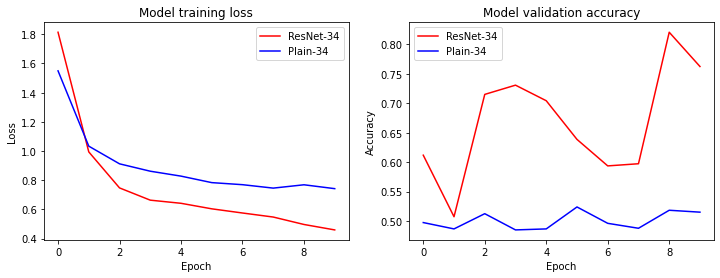

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

### - ResNet-50 vs Plain-50 비교

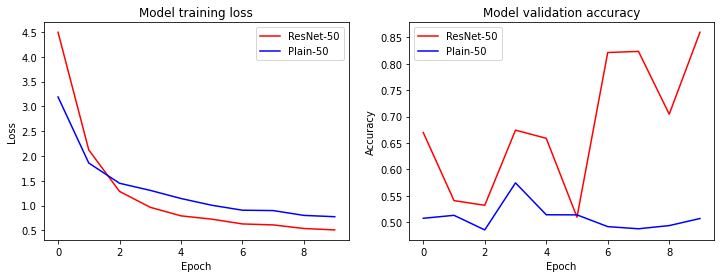

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

### - 전체 비교

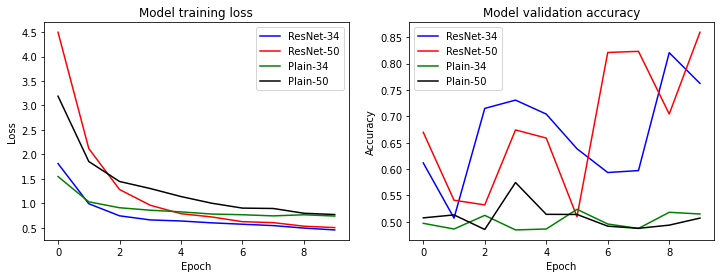

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

# 프로젝트 결과
- Training Loss의 출발점은 Plain 모델이 ResNet보다 낮았는데 학습할수록 ResNet이 더 빠르게 낮아져서, 결국에는 ResNet이 더 낮은 0.5에 가깝게 수렴하였고, Plain 모델은 0.75에 가깝게 수렴한 것을 볼 수 있다.
- Validation Accuracy는 처음부터 ResNet이 높게 시작하여 결국에는 0.8을 넘나드는 것을 볼 수 있는데 Plain 모델은 에폭이 진행되면서 거의 변화가 미미하고 10에폭 후에도 0.55에 조차 도달하지 못하는 그래프를 볼 수 있다. 
- Validation Accuracy 그래프에서 알 수 있는 것은 Plain 모델의 경우는 레이어가 깊어 진다고해서 학습이 잘 되는게 아니라는 것이고 ResNet처럼 skip connection이 존재해야만 레이어가 깊어질수록 학습이 잘된다는 점이다. 왜냐하면 ResNet-34와 ResNet-50 경우에도 에폭이 진행될수록 ResNet-50이 더 가파르게 Validation Accuracy가 증가하는게 보이기 때문이다. 만약 에폭을 더 늘렸다면 ResNet-34와 ResNet-50 사이에도 차이가 더 두드러질 것이라고 예상된다.